**ВСТУПЛЕНИЕ**

**О сложности оценки высоты съемки по фотографиям**

Точная оценка высоты съемки требует либо:

1 - Метаданных камеры - фокусное расстояние, размер сенсора, угол наклона  
2 - Геопривязки - координаты съемки и объектов, цифровые модели рельефа  
3 - Эталонных объектов с известными размерами на снимке  

В нашем случае доступен только третий метод, так как:

- Нет EXIF-данных камеры
- Отсутствуют геопривязки
- Неизвестны точные параметры съемки

_________________________________________________
**Используемый метод оценки**

Высоту можно оценить по формуле фотограмметрии:

`Высота = (GSD × Фокусное_расстояние × Ширина_изображения) / Ширина_сенсора`

где GSD (Ground Sampling Distance) - размер пикселя на местности.

Для расчета GSD нужен объект-эталон с известными реальными размерами. Мы используем **Toyota Tundr**a (джип) со следующими размерами:

- Длина: 5.9 м  
- Ширина: 2.0 м  
- Площадь: 11.8 м²  

  
_________________________________________________
**Проблемы метода и источники погрешности**

1 - Перспективные искажения - объекты в разных частях кадра имеют разный масштаб  
2 - Наклон камеры - съемка редко бывает строго вертикальной  
3 - Изменение высоты - дрон может менять высоту между кадрами  
4 - Определение границ объекта - сложность точного выделения контура  
5 - Предположение о размерах эталона - реальные размеры могут отличаться  

**Цели данного исследования**

1 - Оценить размер здания по автомобилю-эталону  
2 - Проанализировать влияние положения объекта в кадре на измеряемую площадь  
3 - Сравнить расчет высоты по разным объектам (автомобиль и здание)  
4 - Оценить чувствительность измерений к изменению высоты  
5 - Проанализировать погрешности метода  

_________________________________________________
**Используемые данные**

Для анализа взяты три изображения (10845, 10846, 10847), на которых присутствуют:

- Один и тот же автомобиль (Toyota Tundra)
- Одно и то же здание

Для повышения точности была выполнена ручная разметка объектов, исключающая:

- Тени
- Другие мешающие объекты
- Неточности автоматической сегментации

_________________________________________________
**Важное замечание**

Все расчеты имеют **значительную погрешность (до 20%)**, так как основаны на предположениях:

- Камера имеет стандартные параметры дрона (f=8.8 мм, сенсор 1/2.3")
- Объект-эталон имеет точно указанные размеры
- Перспективные искажения не учитываются при расчете площадей

_________________________________________________
**Краткое описание структуры кода:**

1 - `ReferenceBasedSizeCalculator` - расчет размеров одного объекта по эталону с проверкой точности  
2 - `ObjectAreaAnalyzer` - анализ изменения площади объекта в зависимости от положения в кадре  
3 - `HeightEstimator` - оценка высоты съемки по разным объектам  
4 - Визуализация зависимости площади от высоты - показывает чувствительность метода  

_________________________________________________
**Ожидаемые результаты:**

- Демонстрация погрешностей метода оценки высоты
- Количественная оценка влияния положения объекта в кадре
- Практические рекомендации по использованию метода


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

toyota_l = 5.9
toyota_w = 2

def visualize_all_classes(mask_path):
    """Показывает все классы разными цветами."""
    original_path = mask_path.replace('_lab.png', '.jpg')
    img = cv2.imread(original_path)
    msk = cv2.imread(mask_path, 0)
    
    if img is None:
        original_path = mask_path.replace('_lab.png', '.png')
        img = cv2.imread(original_path)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay = img_rgb.copy()
    
    # Цвета для разных классов
    colors = {
        1: [255, 0, 255],    # Фиолетовый - автомобили
        2: [0, 255, 0],      # Зеленый - здания
    }
    
    # Накладываем каждый класс
    for class_id, color in colors.items():
        class_mask = (msk == class_id)
        overlay[class_mask] = (overlay[class_mask] * 0.3 + np.array(color) * 0.7).astype(np.uint8)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(img_rgb); ax1.set_title('Оригинал'); ax1.axis('off')
    ax2.imshow(overlay); ax2.set_title('Все классы'); ax2.axis('off')
    plt.show()

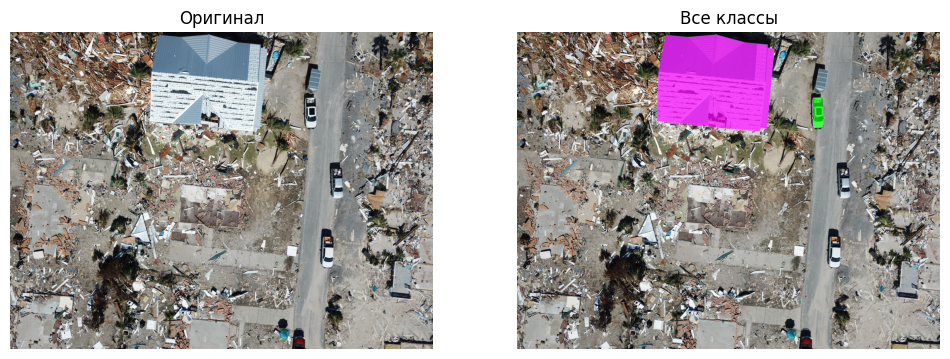

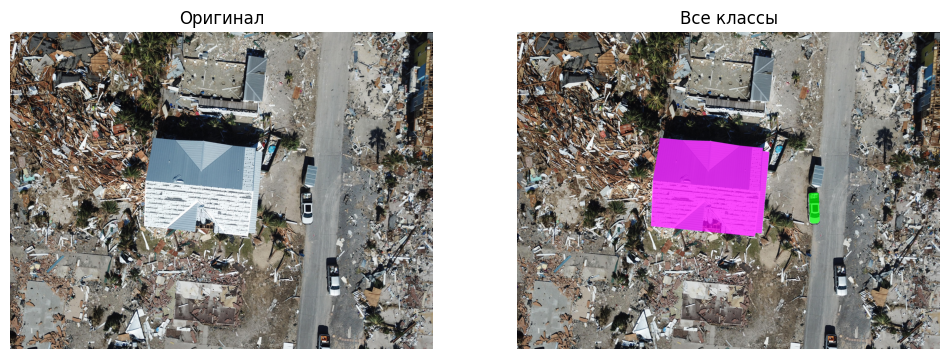

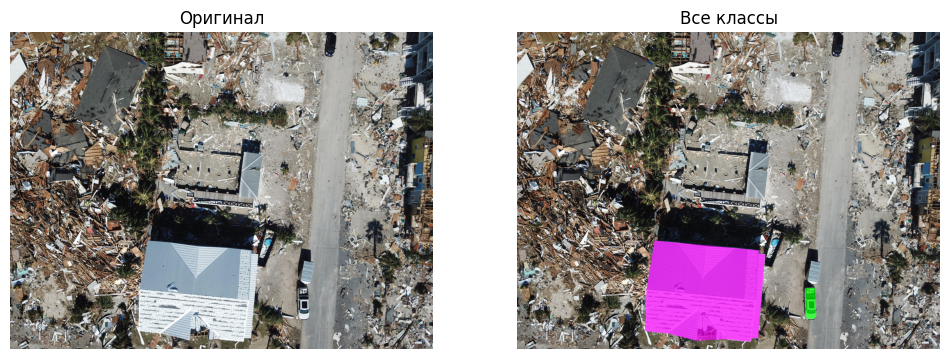

In [2]:
# отображаем изображения, которые возьмем для описанного анализа
for car in (10845, 10846, 10847):
    visualize_all_classes(f"./height_study/Cars_and_Buildings/train/{car}_lab.png")

### Расчет площади одного объекта по объекту-эталону (с перепроверкой эталона)

РАСЧЕТ РАЗМЕРОВ ПО ЭТАЛОНУ
Файл: ./Cars_and_Buildings/train/10846_lab.png
Эталон: класс 2
Размеры эталона: 5.90 м × 2.00 м = 11.8 м²

ЭТАЛОН (класс 2):
  Реальная площадь: 11.8 м²
  Площадь в пикселях: 26176 px²
  GSD: 2.12 см/пикс

ПРОВЕРКА ЭТАЛОНА:
  Пересчитанная площадь: 11.8 м²
  Погрешность: 0.00% ✓

ЦЕЛЕВОЙ ОБЪЕКТ (класс 1):
  Площадь в пикселях: 885186 px²
  Площадь: 399.0 м²
  Ширина: 17.8 м
  Длина: 22.4 м
  Проверка: 22.4 × 17.8 = 399.0 м²


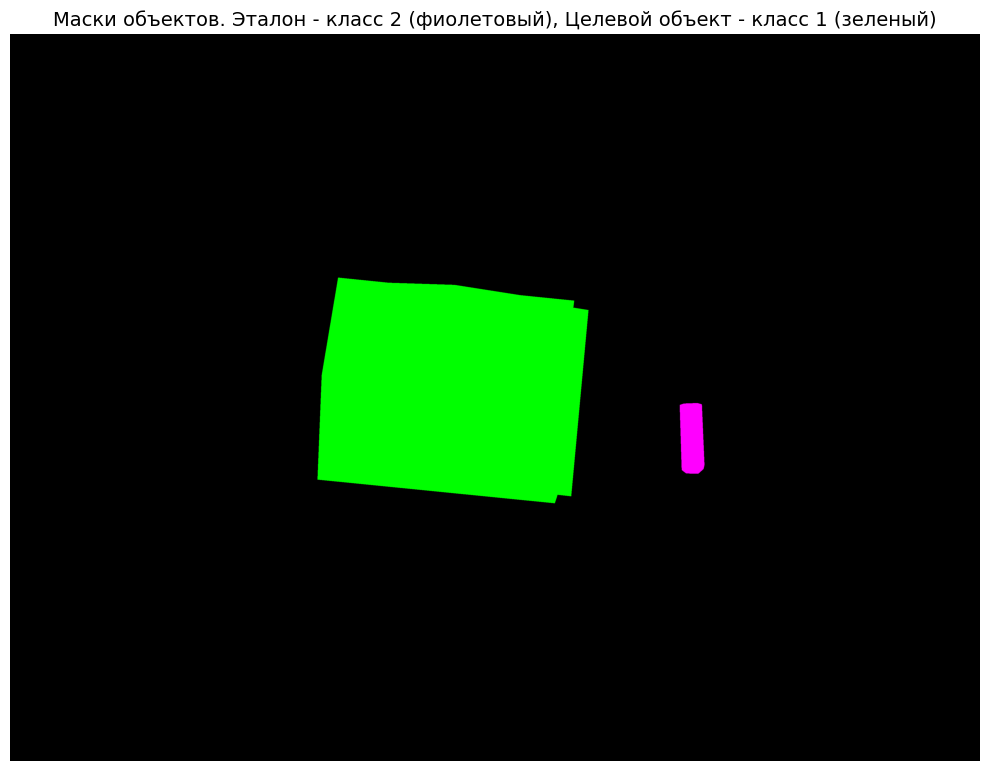


ИТОГИ:
GSD: 2.12 см/пикс
Целевой объект (класс 1):
  22.4 м × 17.8 м = 399.0 м²


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class ReferenceBasedSizeCalculator:
    def __init__(self):
        """Калькулятор размеров объектов на основе объекта-эталона."""
        pass
        
    def calculate_sizes(self, mask_path, reference_class_id, reference_width_m, reference_length_m,
                       target_class_id=None):
        """
        Расчет размеров объектов на основе эталона.
        
        Args:
            mask_path: Путь к файлу маски
            reference_class_id: ID класса объекта-эталона в маске
            reference_width_m: Реальная ширина объекта-эталона (м)
            reference_length_m: Реальная длина объекта-эталона (м)
            target_class_id: ID класса целевого объекта для анализа
        """
        # Загрузка маски
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Не удалось загрузить маску: {mask_path}")
        
        reference_area_m2 = reference_width_m * reference_length_m
        
        print(f"{'='*60}")
        print(f"РАСЧЕТ РАЗМЕРОВ ПО ЭТАЛОНУ")
        print(f"Файл: {mask_path}")
        print(f"Эталон: класс {reference_class_id}")
        print(f"Размеры эталона: {reference_length_m:.2f} м × {reference_width_m:.2f} м = {reference_area_m2:.1f} м²")
        print(f"{'='*60}")
        
        # 1. Находим объект-эталон и вычисляем масштаб
        reference_mask = (mask == reference_class_id).astype(np.uint8)
        ref_contours, _ = cv2.findContours(reference_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not ref_contours:
            raise ValueError(f"Объект-эталон (класс {reference_class_id}) не найден в маске")
        
        # Берем самый большой контур эталона
        ref_contour = max(ref_contours, key=cv2.contourArea)
        ref_area_px = cv2.contourArea(ref_contour)
        
        # ВЫЧИСЛЯЕМ КОЭФФИЦИЕНТ МАСШТАБА ИЗ ПЛОЩАДИ
        pixel_area_m2 = reference_area_m2 / ref_area_px
        gsd = np.sqrt(pixel_area_m2)  # Ground Sampling Distance (м/пикс)
        
        print(f"\nЭТАЛОН (класс {reference_class_id}):")
        print(f"  Реальная площадь: {reference_area_m2:.1f} м²")
        print(f"  Площадь в пикселях: {ref_area_px:.0f} px²")
        print(f"  GSD: {gsd*100:.2f} см/пикс")
        
        # 2. Проверка пересчета эталона
        check_area_m2 = ref_area_px * pixel_area_m2
        error_percent = abs((check_area_m2 - reference_area_m2) / reference_area_m2 * 100)
        
        print(f"\nПРОВЕРКА ЭТАЛОНА:")
        print(f"  Пересчитанная площадь: {check_area_m2:.1f} м²")
        print(f"  Погрешность: {error_percent:.2f}% {'✓' if error_percent < 1 else '⚠️'}")
        
        # 3. Расчет размеров целевого объекта
        results = {
            'gsd_m': gsd,
            'pixel_area_m2': pixel_area_m2,
            'reference': {
                'class_id': reference_class_id,
                'area_m2': reference_area_m2,
                'calculated_area_m2': check_area_m2,
                'error_percent': error_percent,
            },
            'target_object': None
        }
        
        if target_class_id:
            target_mask = (mask == target_class_id).astype(np.uint8)
            target_contours, _ = cv2.findContours(target_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if not target_contours:
                print(f"\nЦелевой объект (класс {target_class_id}) не найден")
            else:
                # Берем самый большой контур
                target_contour = max(target_contours, key=cv2.contourArea)
                target_area_px = cv2.contourArea(target_contour)
                target_area_m2 = target_area_px * pixel_area_m2
                
                # Вычисляем пропорции из минимального bounding box
                rect = cv2.minAreaRect(target_contour)
                aspect_ratio = max(rect[1]) / min(rect[1]) if min(rect[1]) > 0 else 1
                
                # Эффективные размеры из площади
                effective_width = np.sqrt(target_area_m2 / aspect_ratio)
                effective_length = effective_width * aspect_ratio
                
                results['target_object'] = {
                    'class_id': target_class_id,
                    'area_px': target_area_px,
                    'area_m2': target_area_m2,
                    'width_m': effective_width,
                    'length_m': effective_length,
                    'aspect_ratio': aspect_ratio
                }
                
                print(f"\n{'='*60}")
                print(f"ЦЕЛЕВОЙ ОБЪЕКТ (класс {target_class_id}):")
                print(f"{'='*60}")
                print(f"  Площадь в пикселях: {target_area_px:.0f} px²")
                print(f"  Площадь: {target_area_m2:.1f} м²")
                print(f"  Ширина: {effective_width:.1f} м")
                print(f"  Длина: {effective_length:.1f} м")
                print(f"  Проверка: {effective_length:.1f} × {effective_width:.1f} = "
                      f"{effective_length * effective_width:.1f} м²")
        
        # 4. Визуализация
        self.show_colored_mask(mask, reference_class_id, target_class_id)
        
        print(f"\n{'='*60}")
        print("ИТОГИ:")
        print(f"{'='*60}")
        print(f"GSD: {gsd*100:.2f} см/пикс")
        if results['target_object']:
            obj = results['target_object']
            print(f"Целевой объект (класс {obj['class_id']}):")
            print(f"  {obj['length_m']:.1f} м × {obj['width_m']:.1f} м = {obj['area_m2']:.1f} м²")
        
        return results
    
    def show_colored_mask(self, mask, reference_class_id, target_class_id):
        """Визуализация раскрашенной маски."""
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        # Создаем цветную маску
        colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
        
        # Раскрашиваем эталон (фиолетовый)
        ref_mask = (mask == reference_class_id)
        colored_mask[ref_mask] = [255, 0, 255]  # Фиолетовый
        
        # Раскрашиваем целевой объект (зеленый)
        if target_class_id:
            target_mask = (mask == target_class_id)
            colored_mask[target_mask] = [0, 255, 0]  # Зеленый
        
        # Отображаем маску
        ax.imshow(colored_mask)
        
        # Формируем подпись
        if target_class_id:
            title_text = f"Маски объектов. Эталон - класс {reference_class_id} (фиолетовый), Целевой объект - класс {target_class_id} (зеленый)"
        else:
            title_text = f"Маски объектов. Эталон - класс {reference_class_id} (фиолетовый)"
        
        ax.set_title(title_text, fontsize=14)
        ax.axis('off')
        
        plt.tight_layout()
        plt.show()


# Пример использования
if __name__ == "__main__":
    # Создаем калькулятор
    calc = ReferenceBasedSizeCalculator()
    
    # Вычисляем размеры
    results = calc.calculate_sizes(
        mask_path="./height_study/Cars_and_Buildings/train/10846_lab.png",
        reference_class_id=2,
        reference_width_m=2.0,     # Ширина Toyota Tundra ~ 2.0 м
        reference_length_m=5.9,    # Длина Toyota Tundra ~ 5.9 м
        target_class_id=1          # Анализируем здание
    )

In [4]:
building_l = results['target_object']['width_m']
building_w = results['target_object']['length_m']

### Оценим то, как меняется рассчет высоты исходя из положения одного и того же объекта в кадре

In [5]:
def show_images_with_masks(positions_dict):
    """Показывает оригинальные изображения с наложенными масками."""
    fig, axes = plt.subplots(1, len(positions_dict), figsize=(4 * len(positions_dict), 3))
    
    if len(positions_dict) == 1:
        axes = [axes]
    
    for idx, (position_name, mask_path) in enumerate(positions_dict.items()):
        # Находим оригинальное изображение
        image_path = mask_path.replace('_lab.png', '.jpg')
        img = cv2.imread(image_path)
        
        if img is None:
            # Пробуем другой формат
            image_path = image_path.replace('.jpg', '.png')
            img = cv2.imread(image_path)
        
        if img is None:
            print(f"⚠️ Не удалось загрузить: {image_path}")
            continue
        
        # Загружаем маску
        mask = cv2.imread(mask_path, 0)
        if mask is None:
            print(f"⚠️ Не удалось загрузить маску: {mask_path}")
            continue
        
        # Создаем наложение маски
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        overlay = img_rgb.copy()
        
        # Фиолетовый цвет для маски (класс 1)
        object_mask = (mask == 1)
        purple = np.array([255, 0, 255], dtype=np.uint8)
        overlay[object_mask] = (overlay[object_mask] * 0.3 + purple * 0.7).astype(np.uint8)
        
        # Отображаем
        axes[idx].imshow(overlay)
        axes[idx].set_title(f"{position_name}", fontsize=10)
        axes[idx].axis('off')
    
    plt.suptitle("Исходные изображения с масками объектов", fontsize=12)
    plt.tight_layout()
    plt.show()

In [6]:
def calculate_pixel_area(mask_path, class_id, reference_area_m2):
    """
    Универсальная функция расчета площади пикселя.
    
    Args:
        mask_path: Путь к маске
        class_id: ID класса объекта
        reference_area_m2: Реальная площадь объекта-эталона (м²)
    
    Returns:
        dict: Результаты расчета
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Не удалось загрузить маску: {mask_path}")
    
    height, width = mask.shape
    
    # Находим объекты нужного класса
    object_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        raise ValueError(f"Объекты класса {class_id} не найдены в {mask_path}")
    
    # Берем самый большой объект
    largest_contour = max(contours, key=cv2.contourArea)
    area_px = cv2.contourArea(largest_contour)
    
    # Вычисляем метрики
    m2_per_pixel = reference_area_m2 / area_px
    gsd = np.sqrt(m2_per_pixel)  # м/пиксель
    
    # Нормализованная позиция по Y
    x, y, w, h = cv2.boundingRect(largest_contour)
    center_y_norm = 2 * ((y + h/2) / height) - 1  # -1=верх, 1=низ
    center_x_norm = 2 * ((x + w/2) / width) - 1   # -1=лево, 1=право
    
    return {
        'area_px': area_px,
        'm2_per_pixel': m2_per_pixel,
        'gsd_m': gsd,
        'gsd_cm': gsd * 100,
        'y_norm': center_y_norm,
        'x_norm': center_x_norm,
        'width': width,
        'height': height,
        'contour': largest_contour
    }

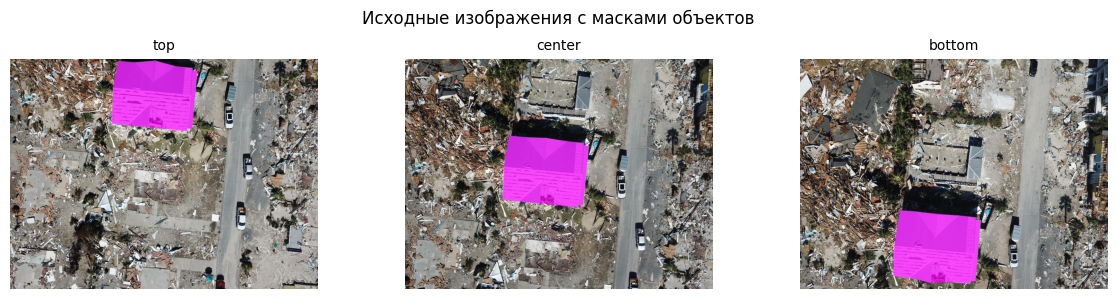


АНАЛИЗ ПЛОЩАДЕЙ ОБЪЕКТОВ
Площадь эталона: 399.0373128056235 м²
Класс объектов: 1

Позиция      Y        Площадь(px²)    м²/пикс      GSD(см/px)   Относ.площадь   Δ площади   
-------------------------------------------------------------------------------------
top          -0.67    871,216         0.000458     2.14         1.028           -           
center       -0.02    885,186         0.000451     2.12         1.012           +1.6%       
bottom       0.64     932,492         0.000428     2.07         0.960           +5.3%       

СТАТИСТИКА ИЗМЕНЕНИЙ
Площадь в пикселях: 871,216 - 932,492 px²
Общее изменение: +7.0%
Пошаговые изменения:
  top → center: +1.6%
  center → bottom: +5.3%


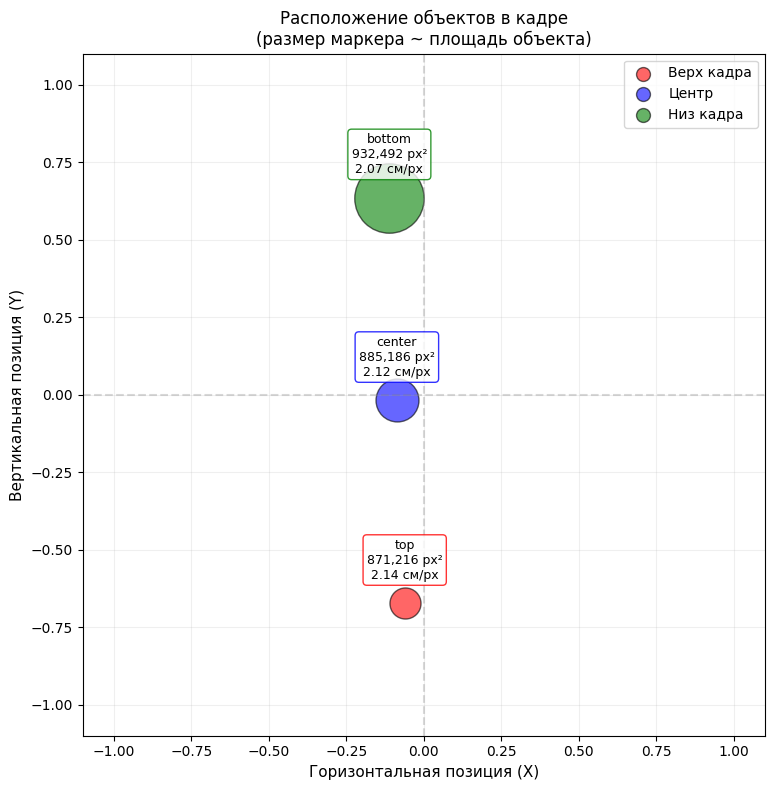

In [7]:
class ObjectAreaAnalyzer:
    def __init__(self, reference_area_m2):
        """
        reference_area_m2: реальная площадь объекта-эталона (м²)
        """
        self.reference_area_m2 = reference_area_m2
        self.results = []
    
    def analyze_position(self, mask_path, position_name, object_class_id=1):
        """Анализ площади объекта на одной позиции."""
        result = calculate_pixel_area(mask_path, object_class_id, self.reference_area_m2)
        result['position'] = position_name
        result['mask_path'] = mask_path
        
        self.results.append(result)
        return result
    
    def analyze_all_positions(self, positions_dict, object_class_id=1):
        """Анализ всех позиций и вывод сводной таблицы."""
        # Показываем изображения с масками
        show_images_with_masks(positions_dict)
        
        # Анализируем каждую позицию
        for position_name, mask_path in positions_dict.items():
            self.analyze_position(mask_path, position_name, object_class_id)
        
        # Сортируем по вертикали
        self.results.sort(key=lambda x: x['y_norm'])
        
        # Вывод заголовка
        print(f"\n{'='*80}")
        print(f"АНАЛИЗ ПЛОЩАДЕЙ ОБЪЕКТОВ")
        print(f"Площадь эталона: {self.reference_area_m2} м²")
        print(f"Класс объектов: {object_class_id}")
        print(f"{'='*80}")
        
        # Вычисляем изменения между соседними позициями
        area_changes = []
        for i in range(1, len(self.results)):
            prev_area = self.results[i-1]['area_px']
            curr_area = self.results[i]['area_px']
            change_percent = ((curr_area - prev_area) / prev_area) * 100
            area_changes.append(change_percent)
        
        # Вывод сводной таблицы
        print(f"\n{'Позиция':<12} {'Y':<8} {'Площадь(px²)':<15} {'м²/пикс':<12} {'GSD(см/px)':<12} {'Относ.площадь':<15} {'Δ площади':<12}")
        print("-" * 85)
        
        # Находим среднее м²/пикс для сравнения
        avg_m2_per_pixel = np.mean([r['m2_per_pixel'] for r in self.results])
        
        for i, r in enumerate(self.results):
            # Относительная площадь (отношение к среднему)
            relative_area = r['m2_per_pixel'] / avg_m2_per_pixel
            
            # Изменение площади
            if i == 0:
                change_str = "-"
            else:
                change_percent = area_changes[i-1]
                change_str = f"{change_percent:+.1f}%"
            
            print(f"{r['position']:<12} {r['y_norm']:<8.2f} "
                  f"{r['area_px']:<15,.0f} {r['m2_per_pixel']:<12.6f} "
                  f"{r['gsd_cm']:<12.2f} {relative_area:<15.3f} {change_str:<12}")
        
        # Статистика
        print(f"\n{'='*80}")
        print(f"СТАТИСТИКА ИЗМЕНЕНИЙ")
        print(f"{'='*80}")
        
        areas_px = [r['area_px'] for r in self.results]
        area_min = min(areas_px)
        area_max = max(areas_px)
        area_change_total = ((area_max - area_min) / area_min) * 100
        
        print(f"Площадь в пикселях: {area_min:,.0f} - {area_max:,.0f} px²")
        print(f"Общее изменение: {area_change_total:+.1f}%")
        
        if area_changes:
            print(f"Пошаговые изменения:")
            for i in range(len(area_changes)):
                from_pos = self.results[i]['position']
                to_pos = self.results[i+1]['position']
                print(f"  {from_pos} → {to_pos}: {area_changes[i]:+.1f}%")
        
        # Визуализация
        self.visualize_results()
        
        return self.results
    
    def visualize_results(self):
        """Визуализация расположения объектов в кадре."""
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        # Рисуем поле кадра
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.axhline(0, color='gray', alpha=0.3, linestyle='--')
        ax.axvline(0, color='gray', alpha=0.3, linestyle='--')
        
        # Находим минимальную и максимальную площади для масштабирования маркеров
        min_area = min([r['area_px'] for r in self.results])
        max_area = max([r['area_px'] for r in self.results])
        
        # Рисуем каждый объект
        for r in self.results:
            # Размер маркера пропорционален площади
            marker_size = 500 + (r['area_px'] - min_area) / (max_area - min_area) * 2000
            
            # Цвет в зависимости от позиции
            if 'top' in r['position'].lower():
                color = 'red'
            elif 'center' in r['position'].lower():
                color = 'blue'
            elif 'bottom' in r['position'].lower():
                color = 'green'
            else:
                color = 'purple'
            
            # Рисуем маркер
            ax.scatter(r['x_norm'], r['y_norm'], 
                      s=marker_size, 
                      color=color, 
                      alpha=0.6,
                      edgecolors='black',
                      linewidth=1)
            
            # Подпись с названием позиции и числовыми значениями
            label = f"{r['position']}\n{r['area_px']:,.0f} px²\n{r['gsd_cm']:.2f} см/px"
            ax.text(r['x_norm'], r['y_norm'] + 0.07, 
                   label, 
                   ha='center', 
                   va='bottom', 
                   fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", 
                            facecolor="white", 
                            alpha=0.8,
                            edgecolor=color))
        
        # Настройки графика
        ax.set_xlabel('Горизонтальная позиция (X)', fontsize=11)
        ax.set_ylabel('Вертикальная позиция (Y)', fontsize=11)
        ax.set_title('Расположение объектов в кадре\n(размер маркера ~ площадь объекта)', fontsize=12)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.2)
        
        # Добавляем легенду
        legend_elements = [
            plt.scatter([], [], s=100, color='red', alpha=0.6, edgecolors='black', label='Верх кадра'),
            plt.scatter([], [], s=100, color='blue', alpha=0.6, edgecolors='black', label='Центр'),
            plt.scatter([], [], s=100, color='green', alpha=0.6, edgecolors='black', label='Низ кадра')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        plt.show()


# Пример использования
if __name__ == "__main__":
    # Создаем анализатор
    analyzer = ObjectAreaAnalyzer(
        reference_area_m2=building_l*building_w 
    )
    
    # Определяем позиции для анализа
    positions = {
        'top': "./height_study/Buildings/train/10845_lab.png",
        'center': "./height_study/Buildings/train/10846_lab.png", 
        'bottom': "./height_study/Buildings/train/10847_lab.png"
    }
    
    # Запускаем анализ (объекты класса 1)
    results = analyzer.analyze_all_positions(positions, object_class_id=1)

**Выводы о съемке:**

**Камера наклонена** - площадь объектов увеличивается к низу кадра (+7% от верха к низу)

**Съемка не строго вертикальная** - есть перспективные искажения (GSD уменьшается сверху вниз)

**Для точных измерений нужна коррекция** - объекты внизу кадра выглядят на 5% больше, чем в центре

### Оцениваем высоту на разных кадрах

In [8]:
import cv2
import numpy as np

class HeightEstimator:
    """
    Оценивает высоту съемки на основе объекта-эталона.
    """
    def __init__(self, reference_area_m2, focal_mm=8.8, sensor_mm=6.17):
        """
        reference_area_m2: реальная площадь объекта-эталона (м²)
        focal_mm: фокусное расстояние камеры (мм)
        sensor_mm: ширина сенсора камеры (мм)
        """
        self.reference_area_m2 = reference_area_m2
        self.f = focal_mm
        self.s = sensor_mm
    
    def analyze(self, mask_path, class_id=1, visualize=True):
        """
        Анализ высоты съемки на одном изображении.
        
        Returns:
            dict: Результаты расчета
        """
        if visualize:
            visualize_all_classes(mask_path)
        
        # Используем общую функцию расчета
        result = calculate_pixel_area(mask_path, class_id, self.reference_area_m2)
        
        # Расчет высоты: H = (GSD * f * W_img) / s
        height = (result['gsd_m'] * self.f * result['width']) / self.s
        
        # Добавляем высоту к результатам
        result['height_m'] = height
        
        return result

In [9]:
# Проверить и автомобиль, и здание на одном снимке
estimator_car = HeightEstimator(reference_area_m2=toyota_l*toyota_w)
estimator_building = HeightEstimator(reference_area_m2=building_l*building_w)

# ОДНО изображение
mask_path = "./height_study/Cars_and_Buildings/train/10846_lab.png"

result_car = estimator_car.analyze(mask_path, class_id=2, visualize=False)  # Автомобиль класс 2
result_building = estimator_building.analyze(mask_path, class_id=1, visualize=False)  # Здание класс 1

print(f"На одном изображении {mask_path}:")
print(f"Автомобиль: площадь пикселя = {result_car['m2_per_pixel']:.6f}, высота = {result_car['height_m']:.1f} м")
print(f"Здание: площадь пикселя = {result_building['m2_per_pixel']:.6f}, высота = {result_building['height_m']:.1f} м")

На одном изображении ./Cars_and_Buildings/train/10846_lab.png:
Автомобиль: площадь пикселя = 0.000451, высота = 121.1 м
Здание: площадь пикселя = 0.000451, высота = 121.1 м


10946
Площадь пикселя: 0.000519 м²
Высота съемки: 130.0
10947
Площадь пикселя: 0.000504 м²
Высота съемки: 128.1
10948
Площадь пикселя: 0.000483 м²
Высота съемки: 125.3


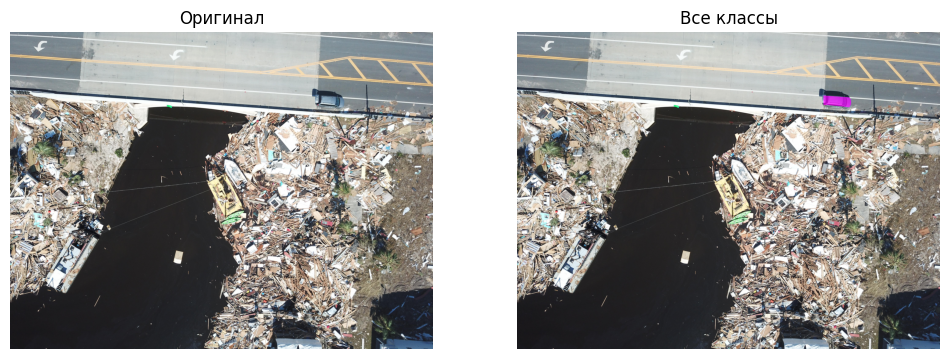

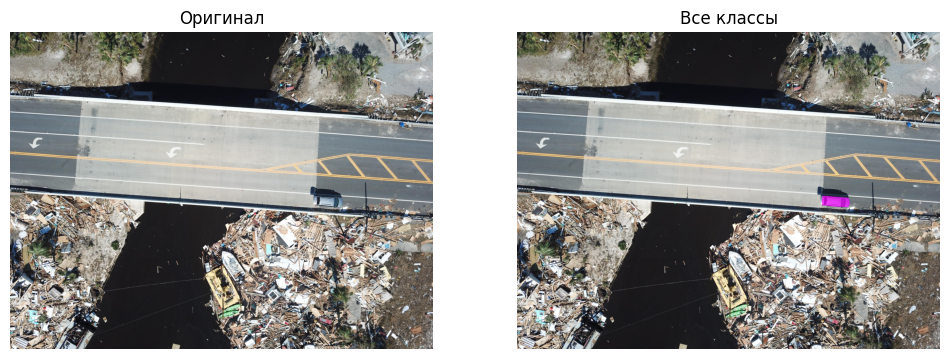

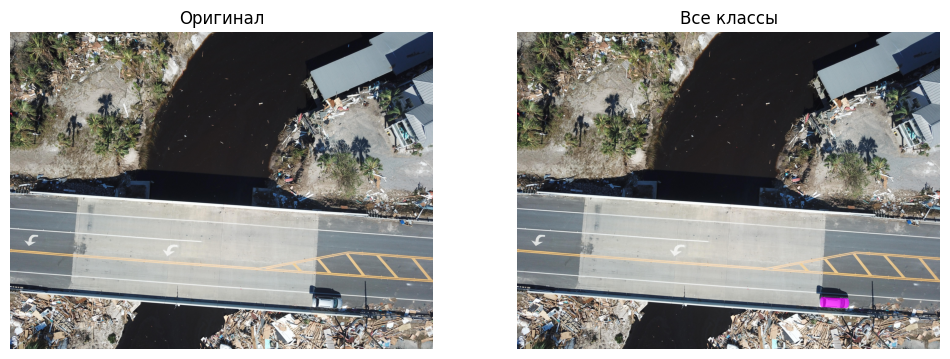

In [10]:
for car in (10946, 10947, 10948):
    result = estimator_car.analyze(f"./height_study/Cars/train/{car}_lab.png", visualize=False)
    print(car)
    print(f"Площадь пикселя: {result['m2_per_pixel']:.6f} м²")
    print(f"Высота съемки: {result['height_m']:.1f}")

for car in (10946, 10947, 10948):
    visualize_all_classes(f"./height_study/Cars/train/{car}_lab.png")

10845
Площадь пикселя: 0.000458 м²
Высота съемки: 122.1 м
10846
Площадь пикселя: 0.000451 м²
Высота съемки: 121.1 м
10847
Площадь пикселя: 0.000428 м²
Высота съемки: 118.0 м


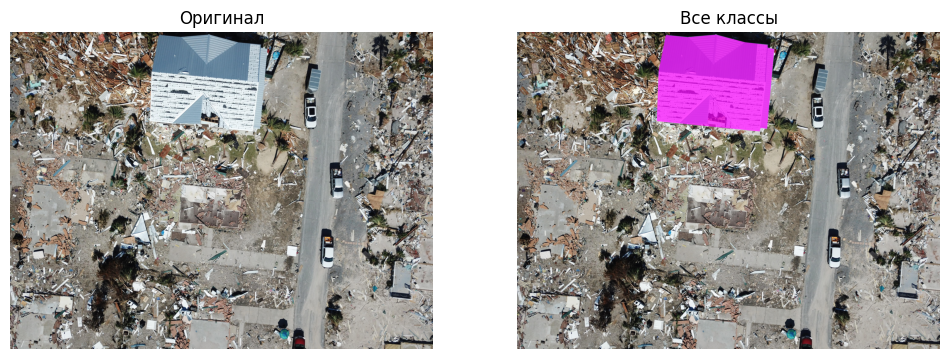

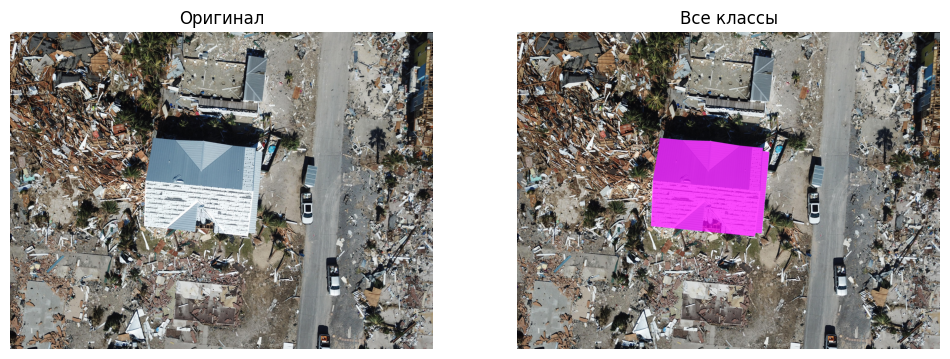

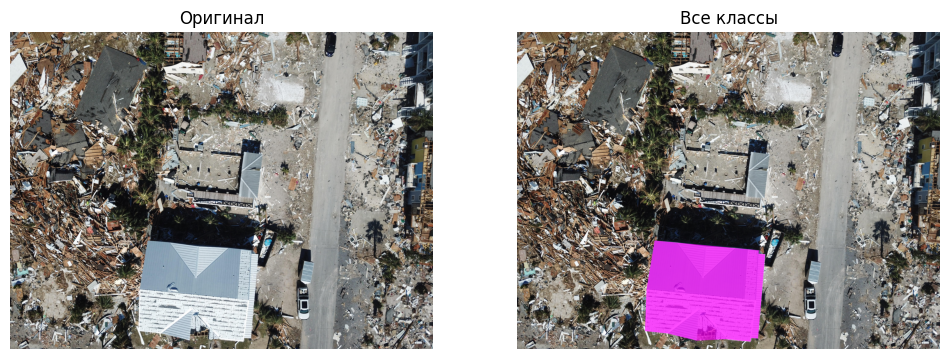

In [11]:
for building in (10845, 10846, 10847):
    result = estimator_building.analyze(f"./height_study/Buildings/train/{building}_lab.png", visualize=False)
    print(building)
    print(f"Площадь пикселя: {result['m2_per_pixel']:.6f} м²")
    print(f"Высота съемки: {result['height_m']:.1f} м")

for building in (10845, 10846, 10847):
    visualize_all_classes(f"./height_study/Buildings/train/{building}_lab.png")

In [13]:
result['m2_per_pixel']

np.float64(0.0004279254930260817)

In [20]:
result['height_m']

np.float64(118.01618712032368)

**На основании средних значений возьмем следующую высоту съемки:**

In [2]:
pixel_area_m2 =  0.000451 
height_m = 121.1

### Взаимосвязь высоты и площади

как сильно меняется расчет площади при изменении высоты

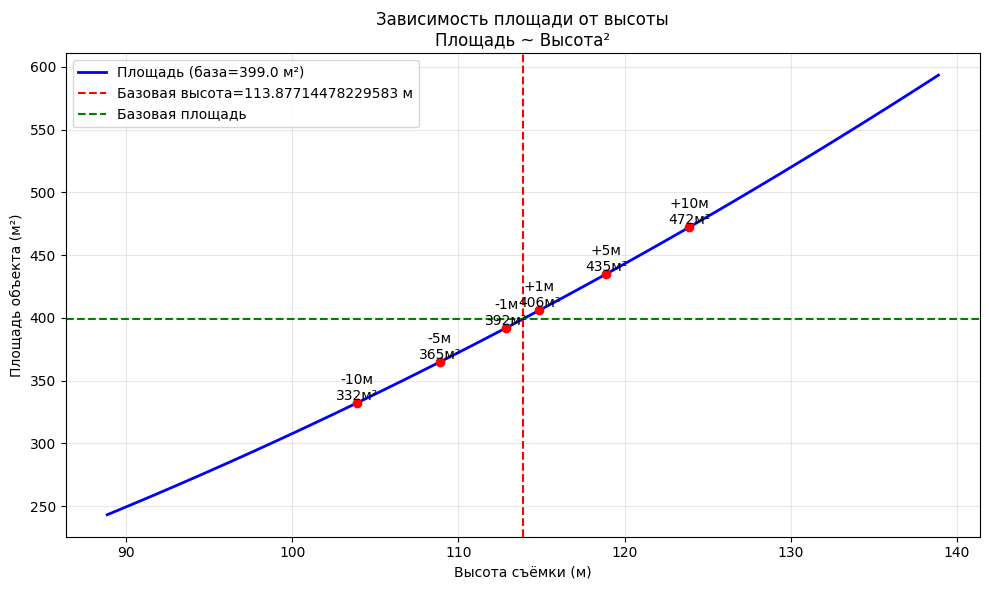

In [20]:
import matplotlib.pyplot as plt

def plot_area_vs_height(base_height, base_area, max_change=20):
    """График зависимости площади от высоты."""
    heights = np.linspace(base_height - max_change, base_height + max_change, 100)
    areas = base_area * (heights / base_height) ** 2
    
    plt.figure(figsize=(10, 6))
    plt.plot(heights, areas, 'b-', linewidth=2, label=f'Площадь (база={base_area:.1f} м²)')
    plt.axvline(x=base_height, color='r', linestyle='--', label=f'Базовая высота={base_height} м')
    plt.axhline(y=base_area, color='g', linestyle='--', label=f'Базовая площадь')
    
    # Отметки
    for delta in [-10, -5, -1, 1, 5, 10]:
        h = base_height + delta
        area = base_area * (h / base_height) ** 2
        plt.plot(h, area, 'ro')
        plt.text(h, area, f'{delta:+}м\n{area:.0f}м²', ha='center', va='bottom')
    
    plt.xlabel('Высота съёмки (м)')
    plt.ylabel('Площадь объекта (м²)')
    plt.title(f'Зависимость площади от высоты\nПлощадь ~ Высота²')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# возьмем за основу площадь здания и высоту, которые мы насчитали ранее
plot_area_vs_height(base_height=result['height_m'], base_area=building_l*building_w, max_change=25)